In [1]:
%matplotlib widget

import lotr.plotting as pltltr
import numpy as np
import pandas as pd
from lotr import A_FISH, FIGURES_LOCATION, LotrExperiment, dataset_folders
from lotr.behavior import get_fictive_heading
from matplotlib import pyplot as plt
from tqdm import tqdm

COLS = pltltr.COLS

In [5]:
exp = LotrExperiment(A_FISH)
stimulus_log = exp.stimulus_log
stimulus_log.set_index("t")
bouts_df = exp.bouts_df

In [7]:
stimulus_log.keys()

Index(['bg_x', 'bg_y', 'bg_theta', 'bg_current_phase', 't'], dtype='object')

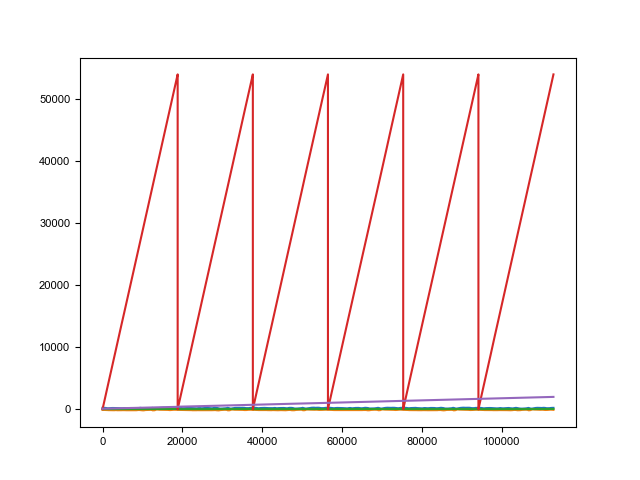

In [6]:
plt.figure()
plt.plot(stimulus_log)